# (16) df: main

**Motivation**: Contains "MC vs. Exact" results, as well as dead neuron, and sparse score results. Device = ```cuda:1``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from analysis.eval import sparse_score
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

## Device

In [2]:
device_idx = 1
device = f'cuda:{device_idx}'

from analysis.final import sort_fits, analyze_fits, add_nelbo_diff
from figures.table import table_entry_loss
from figures.point import nelbo_point
from analysis.stats import ttest

## Load, make df

### Fit names

In [3]:
fits, fits_st, fits_etc = sort_fits()
len(fits), len(fits_st), len(fits_etc)

(460, 90, 527)

### Make df

In [4]:
def accept_fn(name):
    archi = name.split('-')[1]
    accept = (
        archi in ['<lin|lin>', '<conv+b|lin>']
        and '-b' not in name
    )
    return accept


def accept_fn_etc(name):
    archi = name.split('-')[1]
    accept = (
        archi in ['<lin|lin>', '<conv+b|lin>']
        and any(fn in name for fn in ['relu', 'exp'])
        and 'gaussian' in name
        and '-b' not in name
    )
    return accept


fits, fits_st, fits_etc = sort_fits()

fits = sorted(filter(accept_fn, fits))
fits_st = sorted(filter(accept_fn, fits_st))
fits_etc = sorted(filter(accept_fn_etc, fits_etc))

msg = ' ——— '.join([
    f"# fits: {len(fits)}",
    f"# fits_st: {len(fits_st)}",
    f"# fits_etc: {len(fits_etc)}",
])
print(msg)

# fits: 240 ——— # fits_st: 60 ——— # fits_etc: 60

In [5]:
%%time

df_exmc = analyze_fits(fits, device, 'main')
df_st = analyze_fits(fits_st, device, 'main')
df_st['method'] = 'st'
df_etc = analyze_fits(fits_etc, device, 'main')

df = pd.concat([df_exmc, df_st, df_etc]).reset_index(drop=True)

# fix the categorical
cond = (
    (df['type'] == 'categorical') &
    (df['enc_type'] == 'conv') &
    (df['dataset'] == 'MNIST') &
    (df['method'] == 'mc') &
    (df['seed'].isin([2, 3]))
)
df.loc[cond, 'kl'] = np.nan
df.loc[cond, 'kl_diag'] = np.nan
df.loc[cond, 'mse'] = np.nan
df.loc[cond, 'mse_map'] = np.nan
df.loc[cond, 'nelbo'] = np.nan

# savel
save_obj(
    obj=df,
    file_name='df_main',
    save_dir=tmp_dir,
    verbose=True,
    mode='df',
)

100%|███████████████████████████████████████████| 60/60 [00:50<00:00,  1.19it/s]


[PROGRESS] 'df_main.df' saved at
/home/hadi/Dropbox/git/jb-vae/tmp

CPU times: user 2h 58min 28s, sys: 6min 32s, total: 3h 5min
Wall time: 4min 54s


In [9]:
%%time  

for sparse_key in ['lifetime', 'population']:
    df_exmc = analyze_fits(fits, device, 'sparse', sparse_key=sparse_key)
    df_st = analyze_fits(fits_st, device, 'sparse', sparse_key=sparse_key)
    df_st['method'] = 'st'
    df_etc = analyze_fits(fits_etc, device, 'sparse', sparse_key=sparse_key)
    
    df = pd.concat([df_exmc, df_st, df_etc]).reset_index(drop=True)

    # fix the categorical
    cond = (
        (df['type'] == 'categorical') &
        (df['enc_type'] == 'conv') &
        (df['dataset'] == 'MNIST') &
        (df['method'] == 'mc') &
        (df['seed'].isin([2, 3]))
    )
    df.loc[cond, 'kl'] = np.nan
    df.loc[cond, 'kl_diag'] = np.nan
    df.loc[cond, 'mse'] = np.nan
    df.loc[cond, 'mse_map'] = np.nan
    df.loc[cond, 'nelbo'] = np.nan
    
    # savel
    save_obj(
        obj=df,
        file_name=f"df_{sparse_key}",
        save_dir=tmp_dir,
        verbose=True,
        mode='df',
    )

100%|███████████████████████████████████████████| 60/60 [00:52<00:00,  1.14it/s]


[PROGRESS] 'df_lifetime.df' saved at
/home/hadi/Dropbox/git/jb-vae/tmp

100%|███████████████████████████████████████████| 60/60 [00:52<00:00,  1.13it/s]


[PROGRESS] 'df_population.df' saved at
/home/hadi/Dropbox/git/jb-vae/tmp

CPU times: user 6h 5min 52s, sys: 13min 42s, total: 6h 19min 34s
Wall time: 11min 34s


### Load/analyze

In [8]:
df = pjoin(tmp_dir, 'df_lifetime.df')
df = pd.read_pickle(df)

In [9]:
df_selected = df.loc[
    (df['method'] == 'mc') &
    (df['type'] != 'categorical')
]
df_selected = df_selected.groupby(
    ['dataset', 'type', 'enc_type', 'seed']).mean(
    numeric_only=True)['lifetime'].reset_index()

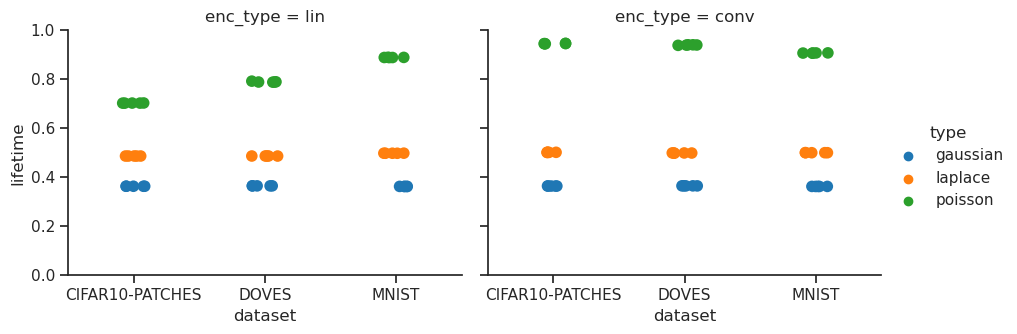

In [10]:
fg = sns.catplot(
    data=df_selected,
    x='dataset',
    hue='type',
    col='enc_type',
    col_order=['lin', 'conv'],
    y='lifetime',
    height=3.5,
    aspect=1.3,
    s=70,
)
fg.axes.flat[0].set(ylim=(0, 1))
plt.show()

In [11]:
df = pjoin(tmp_dir, 'df_main.df')
df = pd.read_pickle(df)

In [12]:
df.loc[df['type'] != 'categorical'].pivot_table(
    index=['dataset', 'enc_type', 'method'],
    columns='type',
    values='active',
)

type                             gaussian   laplace   poisson
dataset         enc_type method                              
CIFAR10-PATCHES conv     exact   0.246094  0.229687  1.000000
                         mc      0.246094  0.230469  0.928125
                         st           NaN       NaN  1.000000
                lin      exact   0.226562  0.198437  0.998437
                         mc      0.105469  0.192969  0.999219
                         st           NaN       NaN  0.998047
DOVES           conv     exact   0.246094  0.224219  1.000000
                         mc      0.246094  0.221875  0.819141
                         st           NaN       NaN  0.998047
                lin      exact   0.222656  0.191406  0.939844
                         mc      0.217578  0.187500  0.983984
                         st           NaN       NaN  0.974219
MNIST           conv     exact   0.042969  0.036719  0.533203
                         mc      0.031250  0.033984  0.426172
                         st           NaN       NaN  0.276953
                lin      exact   0.037109  0.031250  0.519922
                         mc      0.027344  0.027344  0.536719
                         st           NaN       NaN  0.205859

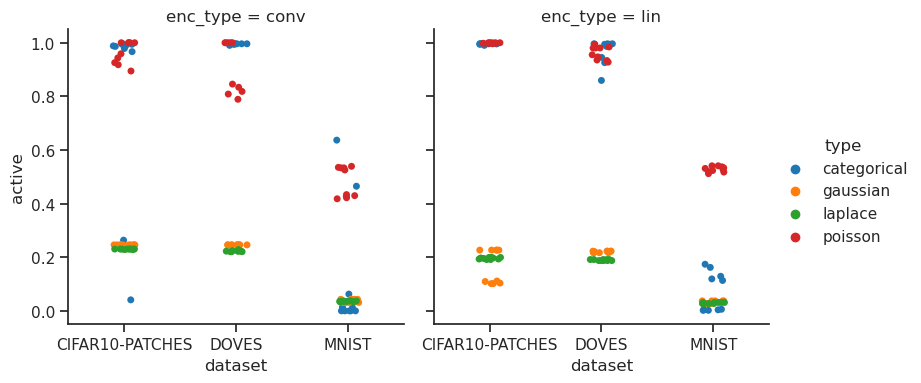

In [13]:
sns.catplot(
    data=df.loc[df['method'] != 'st'],
    x='dataset',
    hue='type',
    col='enc_type',
    y='active',
    height=4,
)

In [14]:
df.loc[df['method'] != 'st'].pivot_table(
    columns=['dataset', 'enc_type'],
    index='type',
    values='active',
)

dataset     CIFAR10-PATCHES               DOVES               MNIST          
enc_type               conv       lin      conv       lin      conv       lin
type                                                                         
categorical        0.819727  0.995313  0.995313  0.968750  0.118945  0.071484
gaussian           0.246094  0.166016  0.246094  0.220117  0.037109  0.032227
laplace            0.230078  0.195703  0.223047  0.189453  0.035352  0.029297
poisson            0.964063  0.998828  0.909570  0.961914  0.479687  0.528320

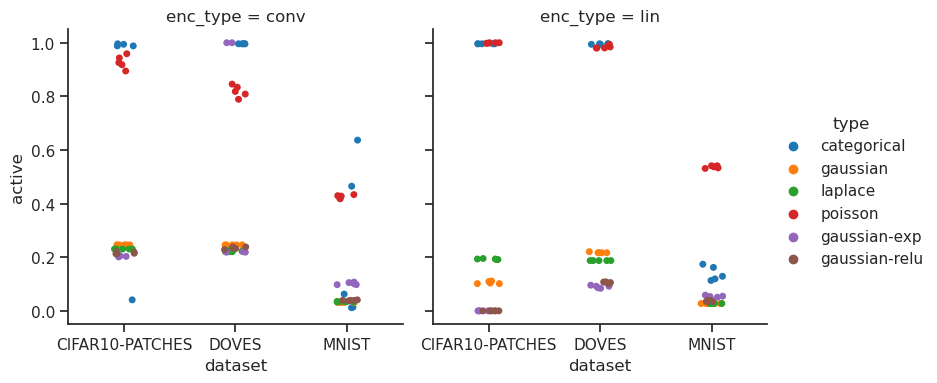

In [7]:
sns.catplot(
    data=df.loc[df['method'] == 'mc'],
    x='dataset',
    hue='type',
    col='enc_type',
    y='active',
    height=4,
)

In [8]:
df.loc[df['method'] == 'mc'].pivot_table(
    columns=['dataset', 'enc_type'],
    index='type',
    values='active',
)

dataset       CIFAR10-PATCHES               DOVES               MNIST  \
enc_type                 conv       lin      conv       lin      conv   
type                                                                    
categorical          0.801562  0.996094  0.996094  0.995313  0.237891   
gaussian             0.246094  0.105469  0.246094  0.217578  0.031250   
gaussian-exp         0.204297  0.000000  0.531641  0.089844  0.101953   
gaussian-relu        0.216016  0.000000  0.234375  0.105859  0.039062   
laplace              0.230469  0.192969  0.221875  0.187500  0.033984   
poisson              0.928125  0.999219  0.819141  0.983984  0.426172   

dataset                  
enc_type            lin  
type                     
categorical    0.139453  
gaussian       0.027344  
gaussian-exp   0.053906  
gaussian-relu  0.036719  
laplace        0.027344  
poisson        0.536719

### Load df

In [4]:
df = pjoin(tmp_dir, 'df_main.df')
df = pd.read_pickle(df)
df = add_nelbo_diff(df)
df.shape

(150, 9)

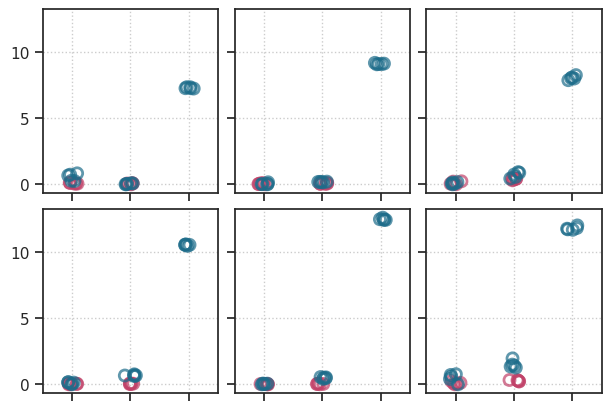

NameError: name 'fig_dir' is not defined

In [5]:
fig, axes = nelbo_point(df, scale=2)
fig.savefig(pjoin(fig_dir, 'nelbo_point.pdf'), **kws_fig)

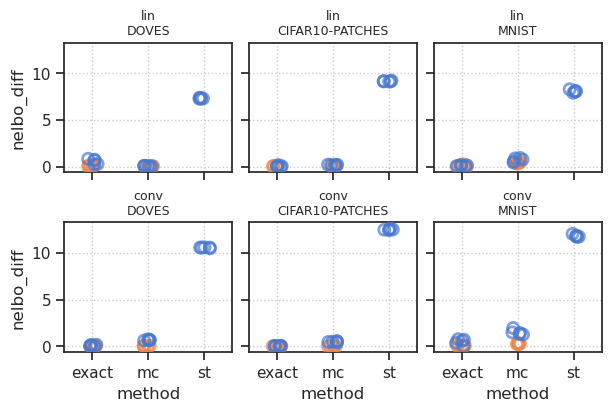

In [25]:
fig, axes = nelbo_point(df, scale=2, remove_lbls=False)

In [6]:
df.groupby(['type', 'method']).mean(numeric_only=True)

seed       nelbo  nelbo_diff
type     method                              
gaussian exact    3.0  118.394539    0.062021
         mc       3.0  118.430450    0.142867
poisson  exact    3.0  123.472893    0.216889
         mc       3.0  123.759293    0.599133
         st       3.0  135.367767    9.887917

In [7]:
group_cols = ['type', 'dataset', 'enc_type', 'method']
df_agg, df_ttest = ttest('nelbo', df, group_cols, test_conds=[('exact', 'mc')])

In [8]:
df_ttest

,type,dataset,enc_type,cond1,cond2,t,pvals,pvals_fdr_bh,reject
0,gaussian,CIFAR10-PATCHES,conv,exact,mc,-1.736704,0.157443,0.171757,False
1,gaussian,CIFAR10-PATCHES,lin,exact,mc,-0.425670,0.692252,0.692252,False
2,gaussian,DOVES,conv,exact,mc,-2.090717,0.104746,0.139661,False
3,gaussian,DOVES,lin,exact,mc,1.843652,0.139009,0.166810,False
4,gaussian,MNIST,conv,exact,mc,-7.369763,0.001806,0.003698,True
5,gaussian,MNIST,lin,exact,mc,-9.279763,0.000750,0.003000,True
6,poisson,CIFAR10-PATCHES,conv,exact,mc,-14.507506,0.000131,0.000788,True
7,poisson,CIFAR10-PATCHES,lin,exact,mc,-6.218841,0.003404,0.005835,True
8,poisson,DOVES,conv,exact,mc,-17.087880,0.000069,0.000788,True
9,poisson,DOVES,lin,exact,mc,4.337745,0.012275,0.018412,False


In [9]:
for model in ['poisson', 'gaussian', 'categorical', 'laplace']:
    table = table_entry_nelbo(model, df_agg)
    print(f"——— model: {model} ———\n")
    print(table)
    print('\n\n\n')

——— model: poisson ———

\begin{tabularx}{34mm}{CC}
    \entry{168.0}{.8} & \entry{162.4}{.2} \\ 
    \entry{167.2}{.1} & \entry{163.4}{.1} \\ 
    \entry{179.3}{.1} & \entry{179.4}{.1}
\end{tabularx}
&
\begin{tabularx}{34mm}{CC}
    \entry{167.1}{.2} & \entry{162.1}{.1} \\ 
    \entry{167.3}{.1} & \entry{162.9}{.2} \\ 
    \entry{182.3}{.1} & \entry{182.3}{.2}
\end{tabularx}
&
\begin{tabularx}{34mm}{CC}
    \entry{41.5}{.1} & \entry{39.7}{.2} \\ 
    \entry{41.7}{.2} & \entry{40.1}{.2} \\ 
    \entry{44.8}{.1} & \entry{44.2}{.1}
\end{tabularx}

——— model: gaussian ———

\begin{tabularx}{34mm}{CC}
    \entry{160.3}{.1} & \entry{154.4}{.1} \\ 
    \entry{160.3}{.1} & \entry{154.4}{.1}
\end{tabularx}
&
\begin{tabularx}{34mm}{CC}
    \entry{165.9}{.1} & \entry{149.2}{.0} \\ 
    \entry{165.9}{.1} & \entry{149.2}{.1}
\end{tabularx}
&
\begin{tabularx}{34mm}{CC}
    \entry{40.6}{.1} & \entry{40.0}{.1} \\ 
    \entry{40.7}{.1} & \entry{40.1}{.0}
\end{tabularx}

——— model: categorical ———

\begin{tabularx}{34mm}{CC}

\end{tabularx}
&
\begin{tabularx}{34mm}{CC}

\end{tabularx}
&
\begin{tabularx}{34mm}{CC}

\end{tabularx}

——— model: laplace ———

\begin{tabularx}{34mm}{CC}

\end{tabularx}
&
\begin{tabularx}{34mm}{CC}

\end{tabularx}
&
\begin{tabularx}{34mm}{CC}

\end{tabularx}